

# Generative Adversarial Networks

In [29]:
WH = 64

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


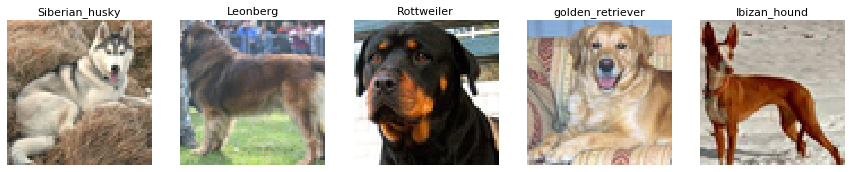

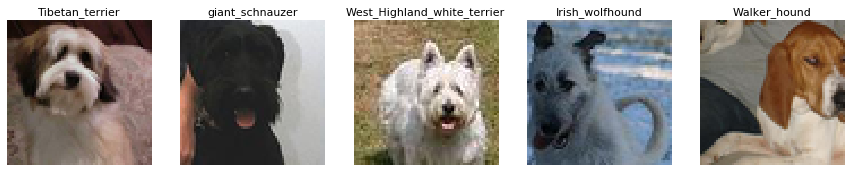

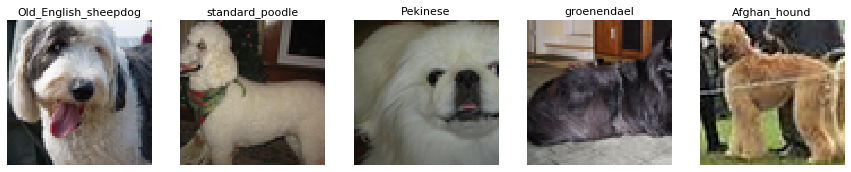

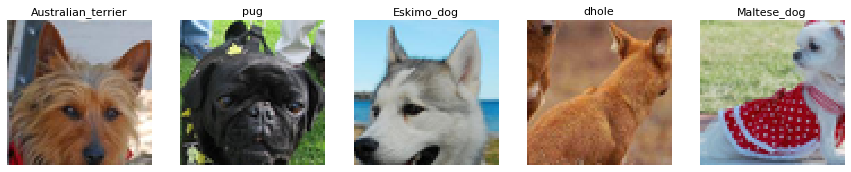

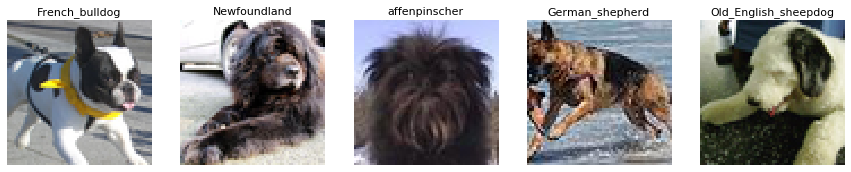

In [15]:
# DogsOnly crop

ComputeLB = False
DogsOnly = True

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))
imagesIn_c = np.zeros((10000,64,64,3))

idx_c = 0

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                width = xmax - xmin
                height = ymax - ymin
                xcenter = (xmax + xmin)/2
                ycenter = (ymax + ymin)/2
                
                w = np.min((width, height))
                
                if width/height > 1.2:
                    img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                    img2 = img2.resize((64,64), Image.ANTIALIAS)
                    imagesIn[idxIn,:,:,:] = np.asarray(img2)                    
                    img2 = img.crop((xmax-w, ymax-w, xmax, ymax))
                    img2 = img2.resize((64,64), Image.ANTIALIAS)
                    imagesIn_c[idx_c,:,:,:] = np.asarray(img2)
                    
                    #print(imagesIn_c.shape)
                    
                    idx_c +=1
                    
#                     print('here')
#                     print(idx_c)
                elif width/height < 1:
                    img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                    img2 = img2.resize((64,64), Image.ANTIALIAS)
                    imagesIn[idxIn,:,:,:] = np.asarray(img2)    
                    
                
                else : 
                    img2 = img.crop((xcenter-w/2, ycenter-w/2, xcenter+w/2, ycenter+w/2))
                    img2 = img2.resize((64,64), Image.ANTIALIAS)
                    imagesIn[idxIn,:,:,:] = np.asarray(img2)
                    
                    
                    
                    
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
                if idxIn%1000==0:
                    print(idxIn)
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20000),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))  
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

(22100, 64, 64, 3)


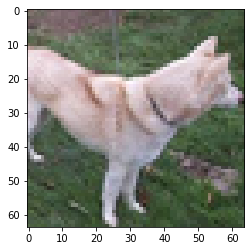

In [37]:
imagesIn_u = imagesIn[:22100]
print(imagesIn_u.shape)
plt.imshow(imagesIn_c[6000]/255)

In [38]:
images_concat = np.append(imagesIn[:22100]/255, imagesIn_c[:6000]/255, axis=0)

In [41]:
images_concat.shape

(28100, 64, 64, 3)

In [40]:
# save as npy file
np.save('../np_v10_min.npy', images_concat)

In [4]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import time
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'1.13.1'

In [ ]:
imagesIn = np.load('../np_v10_min.npy')
imagesIn.shape

In [6]:
BATCH_SIZE = 100
BUFFER_SIZE = 28100
AUTOTUNE = tf.data.experimental.AUTOTUNE
OUTPUT_CHANNELS = 3
EPOCHS = 200
NOISE_DIM = 100
LAMBDA = 100
seed = 1234
WEIGHT_INIT_STDDEV = 0.02

In [7]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [74, 74])
    image = tf.image.random_crop(image, size=[64, 64, 3])
    #image = (image-127.5) / 127.5  # normalize to [-1,1] range
    image = (image / 127.5) - 1
    
    return image

In [35]:
def preprocess_npy(image):

    #image = (image / 127.5) - 1
    image = (image / 0.5) - 1
    #image = tf.image.random_crop(image, [64, 64, 3])
    image = tf.cast(image, tf.float32)
    
    
    return image

0.9568627450980393

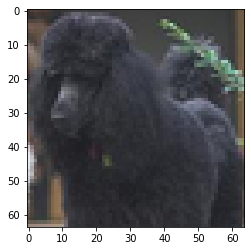

In [37]:
plt.imshow(imagesIn[50])
np.max(imagesIn[50])

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices(imagesIn)
train_dataset = train_dataset.map(preprocess_npy,num_parallel_calls = AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<DatasetV1Adapter shapes: (?, 64, 64, 3), types: tf.float32>

In [44]:
noise = tf.random_normal([BATCH_SIZE, NOISE_DIM])
noise.shape

TensorShape([Dimension(100), Dimension(100)])

# Build the Generator

In [45]:
def make_generator_model():
    inputs = tf.keras.layers.Input(shape=[NOISE_DIM])
    x = inputs
    layers = [
        tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(NOISE_DIM,)),
        tf.keras.layers.Reshape((4, 4, 512)),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005), # (bs, 8, 8, 256)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005), # (bs, 16, 16, 128)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005), # (bs, 32, 32, 64)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005), # (bs, 64, 64, 32)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
#         tf.keras.layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False,
#                                        kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
#         tf.keras.layers.BatchNormalization(epsilon=0.00005), # (bs, 128, 128, 16)
#         tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False,
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV), activation='tanh')
    ] # (bs, 64, 64, 3)
    
    
    
    for i in layers:
        x = i(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    
    

# Build the Discriminator

In [46]:
def make_discriminator_model():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

    layers = [
        tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                               kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #tf.keras.layers.Dropout(0.5),     # (bs, 64, 64, 32)
        
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #tf.keras.layers.Dropout(0.5),    # (bs, 32, 32, 64)
        
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #tf.keras.layers.Dropout(0.5),    # (bs, 16, 16, 128)
        
        tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #tf.keras.layers.Dropout(0.5),    # (bs, 16, 16, 256)
        
        tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV)),
        tf.keras.layers.BatchNormalization(epsilon=0.00005),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #tf.keras.layers.Dropout(0.5),    # (bs, 8, 8, 512)<=x (bs, 4, 4, 512) 
        
        #tf.keras.layers.Reshape((1,4*4*512)), # (bs, 1, 8192) #<=
        tf.keras.layers.Reshape((4*4*512,)), # (bs, 8192) #<=
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Flatten(), # (bs, 8192) #<=
        
    ]

    for i in layers:
        x = i(x)

        
#     last = tf.keras.layers.Conv2D(1, (5, 5), strides=(2, 2), padding='same', 
#                               kernel_initializer=tf.truncated_normal_initializer(stddev=WEIGHT_INIT_STDDEV))(x)    
#     # (bs, 2, 2, 1)
    
    
#     flatten = tf.keras.layers.Reshape((512*4*4,))(x) # (bs, 8192) #<=
    
#     dense_no_act = tf.keras.layers.Dense(100, input_shape=(512*4*4,), activation=None)(flatten)
#     dense_1 = tf.keras.layers.Dense(100, input_shape=(512*4*4,), activation=tf.keras.activations.sigmoid)(flatten)
    
    logits = tf.keras.layers.Dense(1, input_shape=(512*4*4,), activation=None)(x)  #<=
    
    out = tf.keras.layers.Dense(1, input_shape=(512*4*4,), activation=tf.keras.activations.sigmoid)(x) #<=
#     #out = x
    
    return tf.keras.Model(inputs=inputs, outputs=(out, logits, logits))
    



In [47]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# Losses

In [48]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [49]:
def discriminator_loss(disc_real, d_real_logits, disc_fake, d_fake_logits):


    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,labels=tf.ones_like(d_real_logits)*random.uniform(0.9, 1.0)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_logits)))
    
    total_disc_loss = tf.reduce_mean(0.5*(real_loss + fake_loss))

    return total_disc_loss

In [50]:
#def generator_loss(disc_generated_output, gen_output, target):
def generator_loss(disc_real, disc_fake, d_logits_fake):
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(disc_fake)))

    
    return gen_loss

# Checkpoint

In [51]:
# checkpoint_path = "../checkpoints/train"

# ckpt = tf.train.Checkpoint(generator=generator,
#                            discriminator=discriminator,
#                            generator_optimizer=generator_optimizer,
#                            discriminator_optimizer=discriminator_optimizer, step=tf.Variable(1))

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Images function

In [52]:

SAVEDIR = 'test_v10'

if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)
    
input_noise_for_img_gen = tf.random_normal([64, NOISE_DIM], seed=1234)
    
def generate_images(model, epoch):
    
    
    gen_img = model(input_noise_for_img_gen)
    
#     print(input_noise_for_img_gen[0])
#     print(input_noise_for_img_gen[1])

    fig = plt.figure(figsize=(10, 10))


    for i in range(64):
        j = plt.subplot(8, 8, i+1)
        #plt.title(tf.reduce_mean(gen_img[i]))
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(gen_img[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.0005, hspace=0.0005)
    x = plt.show()

    
    #plt.imsave('{}.png'.format(str(epoch)), gen_img[2])
    fig.savefig('{}/{}.png'.format(SAVEDIR, epoch))

# Training

In [53]:
def train(training_ds, epochs):

    for epoch in range(epochs):
        start = time.time()
        
        n = 0
        
        initial_learning_rate = 2e-4
        learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate,
                                                             epoch, 50, 0.84, staircase=True)


        generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
        

#         for real_img in training_ds:
        for real_img in train_dataset:
            start_b = time.time()

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                noise = tf.random_normal([BATCH_SIZE, NOISE_DIM])
                
                noise_d = tf.random_normal(shape=[BATCH_SIZE,WH,WH,3],mean=0.0,stddev=random.uniform(0.0, 0.1),dtype=tf.float32)
                real_noise = real_img+noise_d
                
                
                
                fake_img = generator(noise, training=True)
                disc_real, d_real_logits, d_real_dense1 = discriminator(real_noise, training=True)
                disc_fake, d_fake_logits, d_fake_dense1 = discriminator(fake_img, training=True)

                gen_loss = generator_loss(disc_real, disc_fake, d_fake_logits)
                disc_loss = discriminator_loss(disc_real, d_real_logits, disc_fake, d_fake_logits)

            generator_gradients = gen_tape.gradient(gen_loss, generator.variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.variables)
            
            
            
            generator_optimizer.apply_gradients(zip(generator_gradients, generator.variables))


            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.variables))
            

        
            n += 1
            

            if n%20==0:
                print("gen_loss : {:1.10f} , disc_loss : {:1.10f}, lr : {}, time : {}"
                      .format(gen_loss.numpy(), disc_loss.numpy(), np.array(learning_rate()), time.time()-start_b))

                
        clear_output(wait=True)
        generate_images(generator, epoch + 1)


        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    print('lr:{}', np.array(learning_rate()))

In [54]:
noise.shape

TensorShape([Dimension(100), Dimension(100)])

noise = tf.random_normal(shape=[BATCH_SIZE,64,64,3],mean=0.0,stddev=random.uniform(0.0, 0.1),dtype=tf.float32)
print(noise.shape)
print('.')
for real_img in train_dataset:
    print('.')
addedd = real_img+noise
print(addedd.shape)

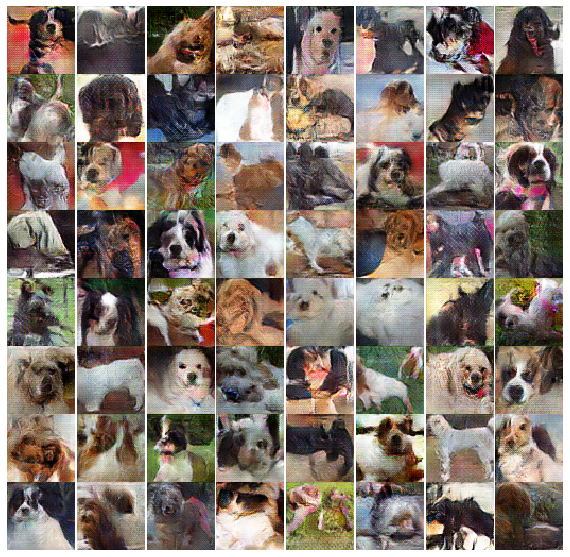

Time taken for epoch 200 is 50.8185555934906 sec

lr:{} 0.00011854078


In [55]:
train(train_dataset, EPOCHS)

In [ ]:
generate_images(generator, 4)

In [1]:
import numpy as np
import tensorflow as tf
SAVEDIR = 'test_v10'
s = (200,720,720,3)
loaded_data_list = np.zeros(s)
for i in range(200):
    loaded_data = tf.io.read_file(SAVEDIR+'/{}.png'.format(i+1))
    image = tf.image.decode_jpeg(loaded_data, channels=3)
    loaded_data_list[i] = image
import imageio
imageio.mimsave(SAVEDIR + '/generated.gif', loaded_data_list)

ValueError: setting an array element with a sequence.

In [ ]:
loaded_data_list_a.shape

In [ ]:
loaded_data = tf.io.read_file(SAVEDIR+'/{}.png'.format(2))

In [ ]:
image = tf.image.decode_jpeg(loaded_data, channels=3)
image